# Analyzing a Decade of NCAA Championship Rankings

As last year's winner of the [Men's March Madness Competition](https://www.kaggle.com/c/mens-machine-learning-competition-2018) I am eager to defend my title.  To kick things off, I wanted to start with a lightweight and fun animation with Plotly.  I chose to look at the Pomeroy Rankings for the last 10 National Championship winnning teams.  The below animation displays the change in the Pomeroy Rankings (team-by-team) for the last 15 weeks of the given regular season.  

Although its a simple animation, there are a few interesting insights that can infered from it.  
* The 2 Connecticut teams (2011 & 2014) were the only teams to have a ranking over 10 at any point in their championship seasons.
* 4 teams never had a rank over 5 at any point in their championship seasons.
* With the exception of the 2 Connecticut teams, all teams ranked in the top 5 at week #1 in the animation.
* Only one of those teams, Duke - 2015, finished outside the top 5 (7) at week #15.

So when I'm filling out my bracket this year and working on the algorithm for the 2019 Competition, I'm going to strongly weight teams that have had consistently strong Pomeroy rankings throughout the season.

Feel free to check out my code and let me know what you think.  Thanks!


In [1]:
#Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML, Image

init_notebook_mode(connected=True)

In [2]:
Image(url='https://cdn1.thr.com/sites/default/files/2015/04/ap947394270639.jpg.jpg')

In [3]:
#Read in Data
massey_df = pd.read_csv('../input/masseyordinals/MasseyOrdinals.csv')
teams = pd.read_csv('../input/datafiles/Teams.csv')

#Merge DataFrames and select only POM rankings
ranks_names = massey_df.merge(teams, how ='left', on = 'TeamID')
ranks_names_pom = ranks_names.loc[ranks_names.SystemName == 'POM']

#Create a dictionary for each year and team champion
champ_dict = OrderedDict([(2018,1437), (2017,1314), 
                          (2016,1437), (2015,1181), 
                          (2014,1163), (2013,1257),
                          (2012,1246), (2011,1163), 
                          (2010,1181), (2009,1314)]
                        )

#Pull the champions by year out of the ranking dataframe.
#Then concatenate them into 1 DF
df_lst = []
for year, team in champ_dict.items():
    subset_df = ranks_names_pom.loc[(ranks_names_pom.Season == year) &
                                    (ranks_names_pom.TeamID == team)
                                   ].tail(15)
    subset_df['rank_week'] = range(1, 16)
    df_lst.append(subset_df)

champ_df = pd.concat(df_lst).reset_index(drop=True)

weeks = list(range(1, 16))
week = 1

#Create the layout for the animation
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

figure['layout']['xaxis'] = {'range': [1, 15.5], 'title': 'Ranking Week','dtick':1,'zeroline':True}
figure['layout']['yaxis'] = {'range': [0, 45], 'title': 'Pomeroy Rankings','dtick':5,'zeroline':True}
figure['layout']['title'] = '2009-2018 NCAA Mens Basketball Champions'
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1',
    'plotlycommand': 'animate',
    'values': weeks,
    'visible': True
}

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Week:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

#Make the Data
for year, team in champ_dict.items():
    dataset_filtered = champ_df.loc[(champ_df.rank_week == week) &
                                    (champ_df.TeamID == team) &
                                    (champ_df.Season == year)].reset_index(drop=True)
    data_dict = {
        'x': list(dataset_filtered['rank_week']),
        'y': list(dataset_filtered['OrdinalRank']),
        'mode': 'markers',
        'text': list(dataset_filtered['TeamID']),
        'marker': {
            'size': 10
        },
        'name': dataset_filtered.TeamName[0] + ' - ' + str(year)
    }
    figure['data'].append(data_dict)
    
    #Make Frames
for week in weeks:
    frame = {'data': [], 'name': str(week)}
    for year, team in champ_dict.items():
        dataset_filtered = champ_df.loc[(champ_df.rank_week == week) &
                                        (champ_df.TeamID == team) &
                                        (champ_df.Season == year)].reset_index(drop=True)
        
        data_dict = {
            'x': list(dataset_filtered['rank_week']),
            'y': list(dataset_filtered['OrdinalRank']),
            'mode': 'markers',
            'text': list(dataset_filtered['TeamID']),
            'marker': {
                'size': 10
            },
            'name': dataset_filtered.TeamName[0] + ' - ' + str(year)
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [week],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': week,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)
    
figure['layout']['sliders'] = [sliders_dict]

iplot(figure)

In [4]:
champ_grouped_df = champ_df.groupby(['Season', 'TeamName'])['OrdinalRank']\
                    .agg(['min', 'max', np.mean, np.std]).round(1)
champ_grouped_df

,,min,max,mean,std
Season,TeamName,,,,
2009,North Carolina,1,5,2.5,1.2
2010,Duke,1,3,1.8,0.7
2011,Connecticut,14,35,23.9,6.5
2012,Kentucky,1,6,2.5,1.5
2013,Louisville,2,4,2.9,0.7
2014,Connecticut,20,44,28.2,6.8
2015,Duke,2,9,5.8,2.6
2016,Villanova,1,8,3.4,2.2
2017,North Carolina,3,10,6.1,2.5


[Text(0,0.5,'Max Rank'),
 Text(0.5,0,'Seasons'),
 Text(0.5,1,'Max Ranking from Champions')]

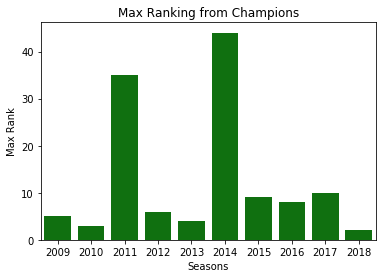

In [5]:
plot_df = champ_grouped_df.reset_index()
ax = sns.barplot(x= 'Season', y = 'max', data = plot_df, color = 'green')
ax.set(xlabel='Seasons', ylabel='Max Rank', title = 'Max Ranking from Champions')